In [1]:
import pandas as pd

# Project Imports
from notebooks.consts import *
from notebooks.preprocessing import preprocess_aso_data, get_unique_genes
from tauso.genome.read_human_genome import get_locus_to_data_dict
from tauso.new_model.data_handling import get_populated_df_with_structure_features

# New Refactored Modules
from tauso.genome.TranscriptMapper import GeneCoordinateMapper, build_gene_sequence_registry
from tauso.algorithms.genomic_context_windows import add_external_mrna_and_context_columns

# Pandas Display Settings
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.width', 2000)
pd.set_option('display.max_columns', None)

In [2]:
# Load and preprocess the dataset
# This handles: Filtering Human, Dropping NaNs, Log Correction, and Pre-mRNA Mapping
all_data = preprocess_aso_data(UPDATED_CSV, include_smiles=False)

print(f"Data ready. Shape: {all_data.shape}")

Preprocessing complete. Final valid rows: 29987
Data ready. Shape: (29987, 29)


In [3]:
from tauso.genome.TranscriptMapper import GeneCoordinateMapper, build_gene_sequence_registry
from tauso.genome.read_human_genome import get_locus_to_data_dict
from tauso.data.data import get_paths

target_genes = get_unique_genes(all_data)

paths = get_paths('GRCh38')
mapper = GeneCoordinateMapper(paths['db'])

# C. Fetch the raw genomic data
# This is the "heavy" part, but limited only to your experimental genes
gene_to_data = get_locus_to_data_dict(include_introns=False, gene_subset=target_genes)

# D. Build the Registry object
# This provides the {gene: {'cds_sequence': '...'}} mapping
ref_registry = build_gene_sequence_registry(
    genes=target_genes,
    gene_to_data=gene_to_data,
    mapper=mapper
)

print(f"Registry rebuilt for {len(ref_registry)} experimental genes.")

Elapsed DB:  0.0002968311309814453
Elapsed Fasta:  0.0002968311309814453
Length:  3267117988
Registry rebuilt for 15 experimental genes.


In [4]:
# Add structural features (e.g. secondary structure energy)
all_data = get_populated_df_with_structure_features(all_data, target_genes, gene_to_data)

Preprocessing ASO Experimental Dataset

Get CDS and premRNA windows

In [5]:
FLANK_SIZES_PREMRNA = [20, 30, 40, 50, 60, 70]
CDS_WINDOWS = [20, 30, 40, 50, 60, 70]

# Run the optimized context generator
df_with_context = add_external_mrna_and_context_columns(
    df=all_data,
    mapper=mapper,
    gene_registry=ref_registry,
    flank_sizes_premrna=FLANK_SIZES_PREMRNA,
    flank_sizes_cds=CDS_WINDOWS
)

print("Genomic context added.")

Genomic context added.


In [6]:
import json
from tauso.data.data import get_data_dir

# Load the centralized weights generated by the CLI
weights_path = Path(get_data_dir()) / "cai_weights.json"

with open(weights_path, 'r') as f:
    cai_weights_map = json.load(f)

print(f"Loaded CAI profiles for: {list(cai_weights_map.keys())}")

Loaded CAI profiles for: ['HEPG2', 'SNU449', 'HELA', 'A431', 'SKMEL28', 'SHSY5Y', 'U251MG', 'NCIH929', 'KMS11', 'NCIH460', 'SKNAS', 'SKNSH', 'Generic']


In [7]:
import numpy as np
import pandas as pd
from tauso.features.cai import calc_CAI
from tauso.data.consts import standardize_cell_line_name

# 1. Initialize the reported fallbacks set once
reported_fallbacks = set()

def get_context_cai(row, sequence, weight_map):
    """
    Selects weights based on row's Cell_line from the centralized weight_map.
    Uses the 'Generic' key as a fallback.
    """
    if pd.isna(sequence) or not str(sequence).strip():
        return np.nan

    cell_line_raw = row.get(CELL_LINE)
    cell_line_name = standardize_cell_line_name(cell_line_raw)

    # 2. Logic simplified: Everything is in the one weight_map dictionary now
    if cell_line_name in weight_map:
        weights = weight_map[cell_line_name]
    else:
        if cell_line_name not in reported_fallbacks:
            print(f"⚠️  Cell line '{cell_line_name}' not found in weights file. Using 'Generic' profile.")
            reported_fallbacks.add(cell_line_name)
        weights = weight_map.get('Generic')

    if not weights:
        return np.nan

    return calc_CAI(str(sequence), weights)

# --- A. Local CAI Windows ---
print("Applying context-specific CAI scores to windows...")
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    cai_col   = f"CAI_score_{flank}_CDS"

    if local_col in df_with_context.columns:
        # Note: we no longer need to pass global_fallback_weights separately
        df_with_context[cai_col] = df_with_context.apply(
            lambda row: get_context_cai(row, row[local_col], cai_weights_map),
            axis=1
        )

# --- B. Global CAI (Full Gene CDS) ---
def get_global_cai_context(row):
    gene = row.get(CANONICAL_GENE)

    # Check the registry built during the CLI stage
    entry = ref_registry.get(gene)
    if not entry or not entry.get('cds_sequence'):
        return np.nan

    return get_context_cai(row, entry['cds_sequence'], cai_weights_map)

if CANONICAL_GENE in df_with_context.columns:
    print("Calculating Global CDS CAI Scores...")
    df_with_context["CAI_score_global_CDS"] = df_with_context.apply(
        get_global_cai_context,
        axis=1
    )

print("Calculation Complete.")

Applying context-specific CAI scores to windows...
⚠️  Cell line 'KARPAS229' not found in weights file. Using 'Generic' profile.
⚠️  Cell line 'MM1R' not found in weights file. Using 'Generic' profile.
⚠️  Cell line 'HEPARG' not found in weights file. Using 'Generic' profile.
⚠️  Cell line 'CC2580' not found in weights file. Using 'Generic' profile.
Calculating Global CDS CAI Scores...
⚠️  Cell line 'HUMANIPS' not found in weights file. Using 'Generic' profile.
⚠️  Cell line 'H929' not found in weights file. Using 'Generic' profile.
Calculation Complete.


In [8]:
from notebooks.features.feature_extraction import save_feature
from notebooks.utils.correlation_test import analyze_feature_correlations, plot_feature_correlations_by_prefix

# 1. Define list of new features
cai_feature_list = [f"CAI_score_{flank}_CDS" for flank in CDS_WINDOWS] + ["CAI_score_global_CDS"]

In [9]:
# 3. Analyze Correlations
results_df = analyze_feature_correlations(df_with_context, target='log_inhibition')

# Display Table
print("Correlation Results:")
display(results_df[results_df['Feature'].isin(cai_feature_list)])

/home/michael/career/tauso_article/tauso_source3/notebooks/features/RNaseH/correlation_test.py:72: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, pearson_p = pearsonr(x, y)
/home/michael/career/tauso_article/tauso_source3/notebooks/features/RNaseH/correlation_test.py:73: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, spearman_p = spearmanr(x, y)


Correlation Results:


,Feature,Pearson,Spearman,NMI_max
58,CAI_score_global_CDS,-0.050,-0.049,0.073
52,CAI_score_20_CDS,-0.149,-0.171,0.050
53,CAI_score_30_CDS,-0.113,-0.156,0.047
54,CAI_score_40_CDS,-0.128,-0.151,0.043
57,CAI_score_70_CDS,-0.119,-0.137,0.039
56,CAI_score_60_CDS,-0.116,-0.150,0.038
55,CAI_score_50_CDS,-0.141,-0.152,0.038


In [10]:
df_with_context[df_with_context['CAI_score_60_CDS'].notna()]

,index,ISIS,Target_gene,Cell_line,Density(cells/well),Transfection,ASO_volume(nM),Treatment_Period(hours),Primer_probe_set,Sequence,Modification,Location,Chemical_Pattern,Linkage,Linkage_Location,Inhibition(%),seq_length,Canonical Gene Name,Cell line organism,Transcript,Location_in_sequence,Location_div_by_length,true_length_of_seq,mod_scan,cell_line_uniform,log_inhibition,sense_sequence,sense_start,sense_length,sense_start_from_end,sense_exon,sense_intron,sense_utr,sense_type,in_coding_region,flank_sequence_20,flank_sequence_30,flank_sequence_40,flank_sequence_50,flank_sequence_60,flank_sequence_70,local_coding_region_around_ASO_20,local_coding_region_around_ASO_30,local_coding_region_around_ASO_40,local_coding_region_around_ASO_50,local_coding_region_around_ASO_60,local_coding_region_around_ASO_70,region_is_local_20,region_is_local_30,region_is_local_40,region_is_local_50,region_is_local_60,region_is_local_70,CAI_score_20_CDS,CAI_score_30_CDS,CAI_score_40_CDS,CAI_score_50_CDS,CAI_score_60_CDS,CAI_score_70_CDS,CAI_score_global_CDS
1,1,540747,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,TATAATGGTGAATATC,cEt/5-methylcytosines/deoxy,0?1?2?13?14?15/C/else,CCCddddddddddCCC,phosphorothioate,else,7.0,16,KRAS,human,NaN,23686.0,0.518395,16,0,A431,-4.532707,GATATTCACCATTATA,23686,16,21998,0,0,0,intron,True,ATAATACTAAATCATTTGAAGATATTCACCATTATAGGTGGGTTTA...,TTTGCCATAAATAATACTAAATCATTTGAAGATATTCACCATTATA...,TCTTTGTGTATTTGCCATAAATAATACTAAATCATTTGAAGATATT...,GGGAGGGCTTTCTTTGTGTATTTGCCATAAATAATACTAAATCATT...,ATGAGGACTGGGGAGGGCTTTCTTTGTGTATTTGCCATAAATAATA...,GGACCAGTACATGAGGACTGGGGAGGGCTTTCTTTGTGTATTTGCC...,GATTGCAAGTGTGAGCCACCGCGCCTAGACCATGGTAGTAGTACTG...,AAGTGTTGGGATTGCAAGTGTGAGCCACCGCGCCTAGACCATGGTA...,GGCCTCCCAAAGTGTTGGGATTGCAAGTGTGAGCCACCGCGCCTAG...,TCCGCCCACCTCGGCCTCCCAAAGTGTTGGGATTGCAAGTGTGAGC...,ACCTCATGATCCGCCCACCTCGGCCTCCCAAAGTGTTGGGATTGCA...,GATCTCCTGACCTCATGATCCGCCCACCTCGGCCTCCCAAAGTGTT...,1,1,1,1,1,1,0.712513,0.767747,0.774909,0.790089,0.801118,0.808296,0.794700
3,3,651479,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,GGTGAATATCTTCAAA,cEt/5-methylcytosines/deoxy,0?1?2?13?14?15/C/else,CCCddddddddddCCC,phosphorothioate,else,28.0,16,KRAS,human,NaN,23680.0,0.518264,16,0,A431,-4.276805,TTTGAAGATATTCACC,23680,16,22004,0,0,0,intron,True,CCATAAATAATACTAAATCATTTGAAGATATTCACCATTATAGGTG...,TGTGTATTTGCCATAAATAATACTAAATCATTTGAAGATATTCACC...,GGGCTTTCTTTGTGTATTTGCCATAAATAATACTAAATCATTTGAA...,GGACTGGGGAGGGCTTTCTTTGTGTATTTGCCATAAATAATACTAA...,CAGTACATGAGGACTGGGGAGGGCTTTCTTTGTGTATTTGCCATAA...,AATGAGGGACCAGTACATGAGGACTGGGGAGGGCTTTCTTTGTGTA...,TGTTGGGATTGCAAGTGTGAGCCACCGCGCCTAGACCATGGTAGTA...,CTCCCAAAGTGTTGGGATTGCAAGTGTGAGCCACCGCGCCTAGACC...,CACCTCGGCCTCCCAAAGTGTTGGGATTGCAAGTGTGAGCCACCGC...,TCATGATCCGCCCACCTCGGCCTCCCAAAGTGTTGGGATTGCAAGT...,CTCCTGACCTCATGATCCGCCCACCTCGGCCTCCCAAAGTGTTGGG...,GTTCTTGATCTCCTGACCTCATGATCCGCCCACCTCGGCCTCCCAA...,1,1,1,1,1,1,0.755155,0.752607,0.764099,0.787668,0.795760,0.800212,0.794700
16,16,663467,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,TGGTGAATATCTTCAA,cEt/5-methylcytosines/deoxy,0?1?2?13?14?15/C/else,CCCddddddddddCCC,phosphorothioate,else,9.0,16,KRAS,human,NaN,23681.0,0.518286,16,0,A431,-4.510969,TTGAAGATATTCACCA,23681,16,22003,0,0,0,intron,True,CATAAATAATACTAAATCATTTGAAGATATTCACCATTATAGGTGG...,GTGTATTTGCCATAAATAATACTAAATCATTTGAAGATATTCACCA...,GGCTTTCTTTGTGTATTTGCCATAAATAATACTAAATCATTTGAAG...,GACTGGGGAGGGCTTTCTTTGTGTATTTGCCATAAATAATACTAAA...,AGTACATGAGGACTGGGGAGGGCTTTCTTTGTGTATTTGCCATAAA...,ATGAGGGACCAGTACATGAGGACTGGGGAGGGCTTTCTTTGTGTAT...,TGGGATTGCAAGTGTGAGCCACCGCGCCTAGACCATGGTAGTAGTA...,CTCCCAAAGTGTTGGGATTGCAAGTGTGAGCCACCGCGCCTAGACC...,CACCTCGGCCTCCCAAAGTGTTGGGATTGCAAGTGTGAGCCACCGC...,TGATCCGCCCACCTCGGCCTCCCAAAGTGTTGGGATTGCAAGTGTG...,CTCCTGACCTCATGATCCGCCCACCTCGGCCTCCCAAAGTGTTGGG...,GTTCTTGATCTCCTGACCTCATGATCCGCCCACCTCGGCCTCCCAA...,1,1,1,1,1,1,0.743465,0.756045,0.764099,0.787820,0.799811,0.800212,0.794700
19,19,695785,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,AATGGTGAATATCTTC,cEt/5-me

Features to analyze: ['CAI_score_20_CDS', 'CAI_score_30_CDS', 'CAI_score_40_CDS', 'CAI_score_50_CDS', 'CAI_score_60_CDS', 'CAI_score_70_CDS', 'CAI_score_global_CDS']
Running per-cohort analysis...
Analyzing 23 cohorts...
Generating plots for 6 features...


/tmp/ipykernel_532349/1453627545.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


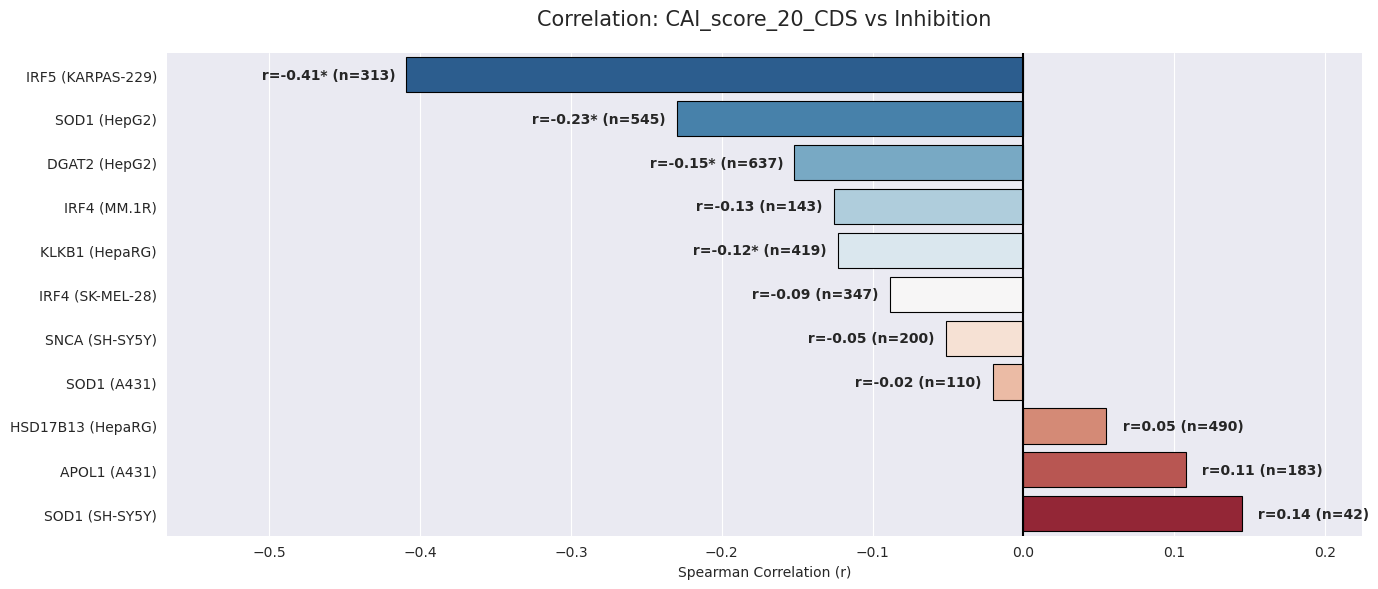

/tmp/ipykernel_532349/1453627545.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


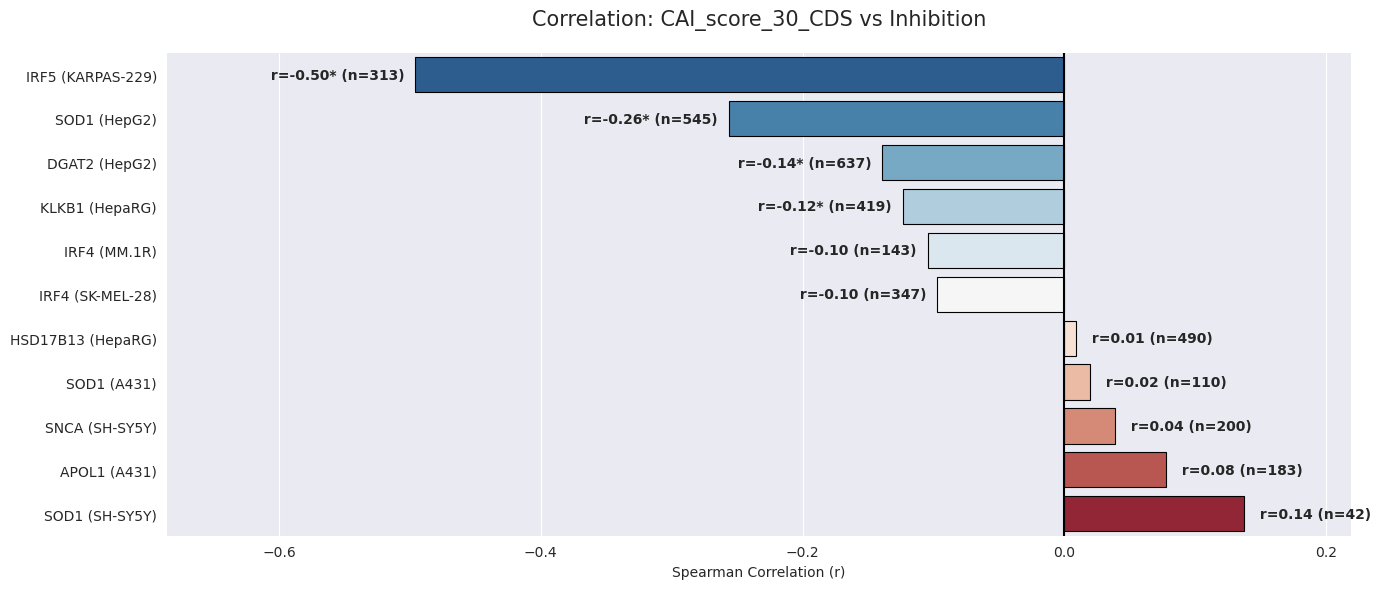

/tmp/ipykernel_532349/1453627545.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


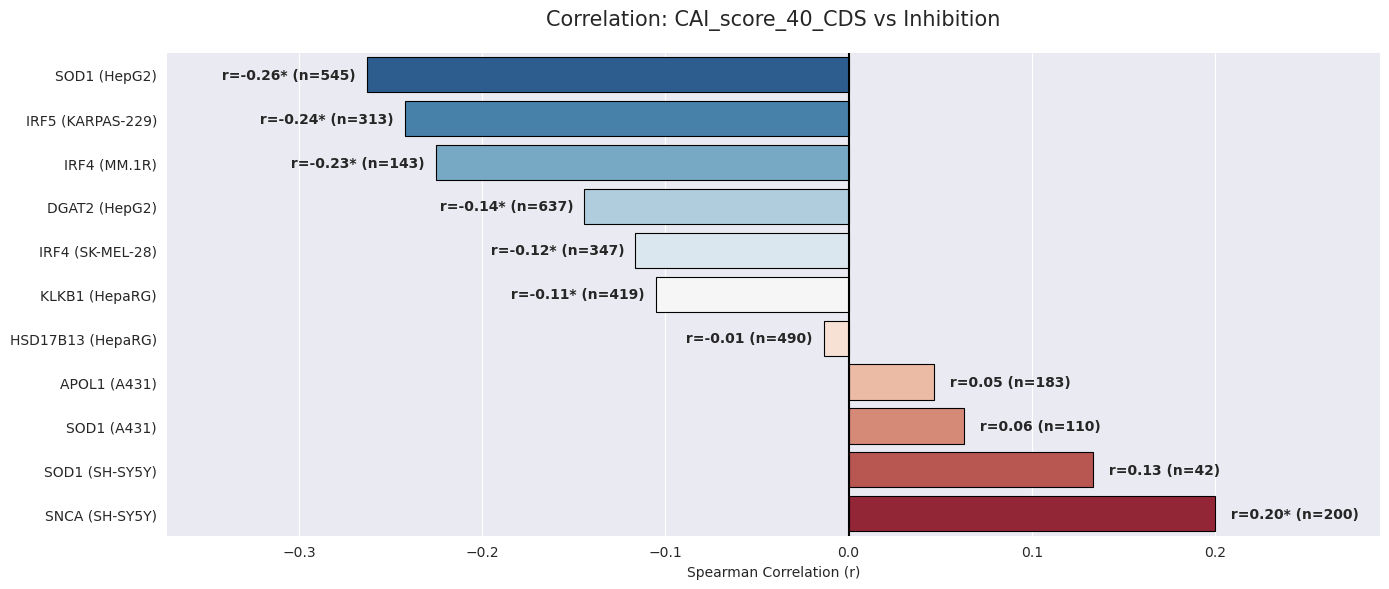

/tmp/ipykernel_532349/1453627545.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


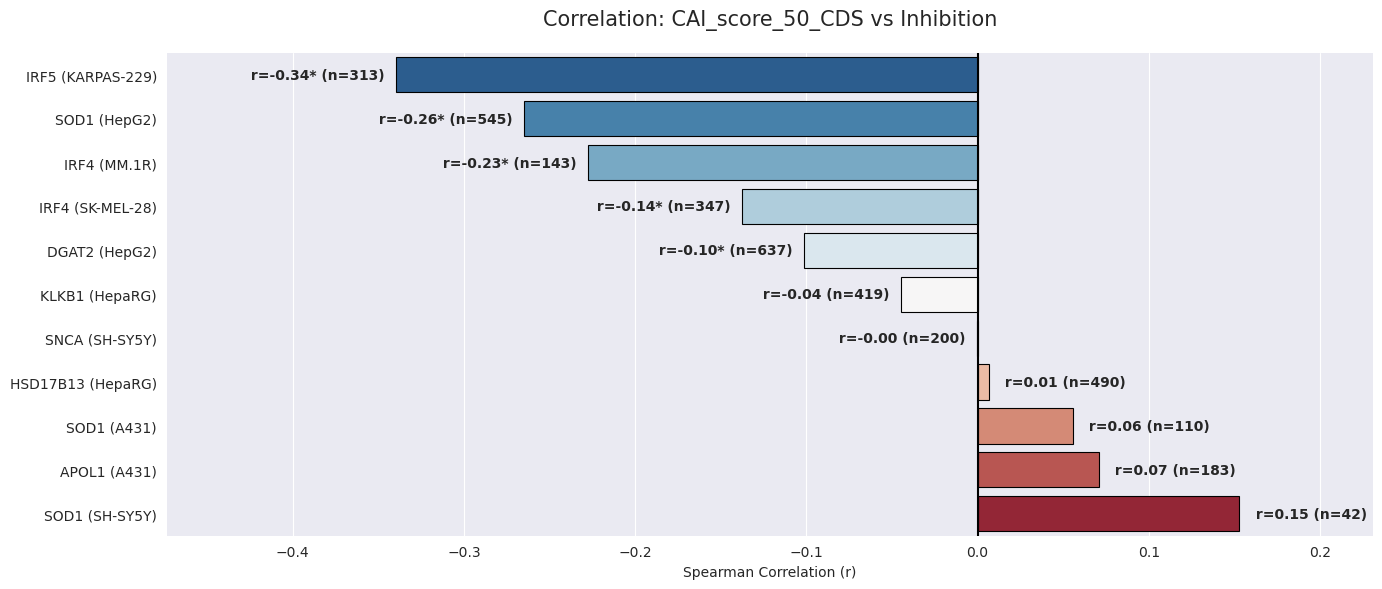

/tmp/ipykernel_532349/1453627545.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


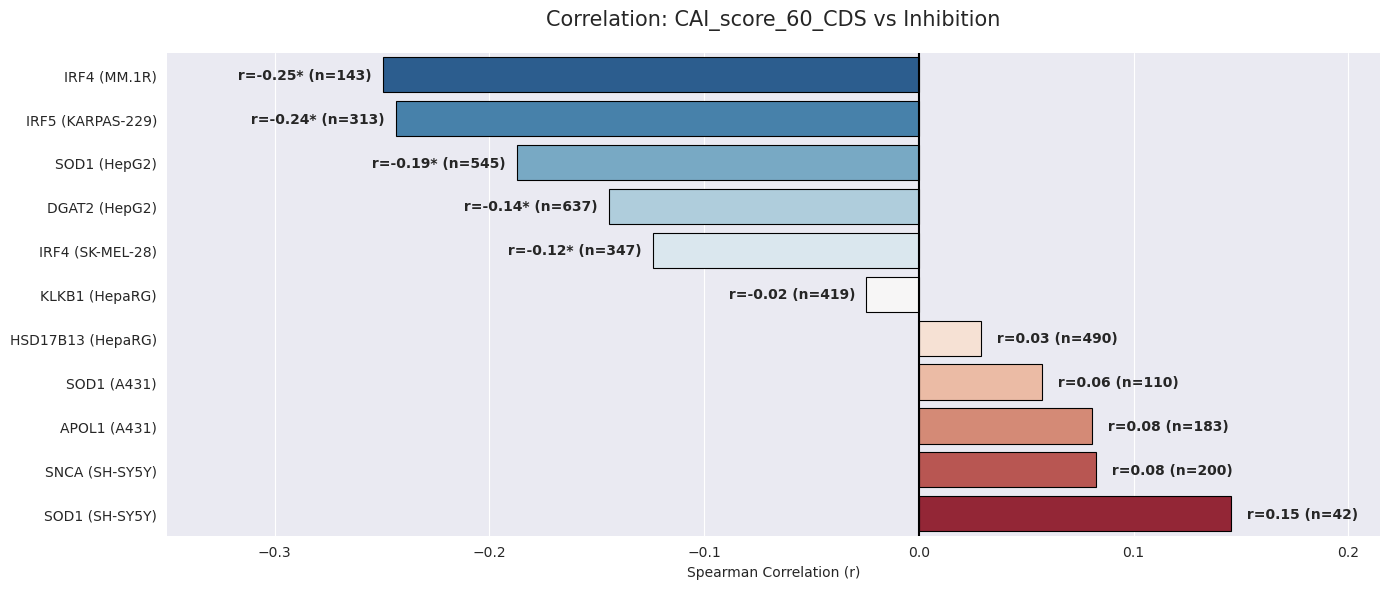

/tmp/ipykernel_532349/1453627545.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


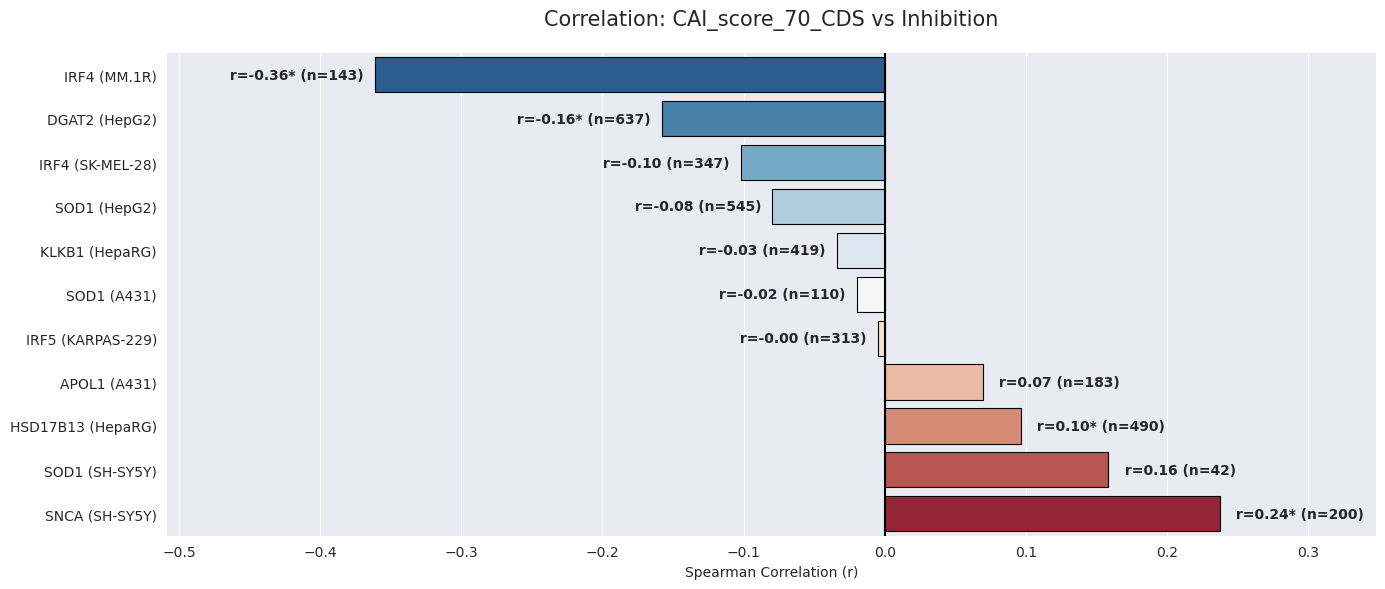

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# --- STEP 1: GENERATE DATA (PER COHORT ANALYSIS) ---
def analyze_correlations_per_cohort(df, target, features, cohort_cols=['Cell_line', CANONICAL_GENE]):
    results = []
    # Group by Cell Line and Gene
    grouped = df.groupby(cohort_cols)
    print(f"Analyzing {len(grouped)} cohorts...")

    for (cell_line, gene), group in grouped:
        if len(group) < 20: continue # Skip small cohorts

        for feature in features:
            if feature not in group.columns: continue

            # Get valid data for this specific feature + target pair
            valid_data = group[[feature, target]].dropna()

            # Skip if variance is 0 (e.g. Global CAI for a single gene)
            if valid_data[feature].nunique() <= 1: continue

            rho, p_val = spearmanr(valid_data[feature], valid_data[target])

            if pd.notna(rho):
                results.append({
                    'Cell_Line': cell_line,
                    'Gene': gene,
                    'Feature': feature,
                    'Spearman_Rho': rho,
                    'P_Value': p_val,
                    'N_Samples': len(valid_data)
                })

    return pd.DataFrame(results)

# 1. Define Feature List (Dynamic based on what exists)
cai_feature_list = [f for f in df_with_context.columns if "CAI_score_" in f]
print(f"Features to analyze: {cai_feature_list}")

# 2. Run Analysis
print("Running per-cohort analysis...")
cohort_results_df = analyze_correlations_per_cohort(
    df_with_context,
    target='log_inhibition',
    features=cai_feature_list
)

# --- STEP 2: PLOT ALL FEATURES (FOREST PLOT) ---
def plot_correlation_forest(df_results, feature_name):
    MIN_SAMPLES = 20

    # Filter Data for this specific feature
    plot_data = df_results[
        (df_results['Feature'] == feature_name) &
        (df_results['N_Samples'] >= MIN_SAMPLES)
    ].copy()

    if plot_data.empty:
        print(f"Skipping {feature_name}: No cohorts met criteria (n>={MIN_SAMPLES}).")
        return

    # Create Label: "Gene (Cell Line)"
    plot_data['Cohort_Label'] = plot_data['Gene'] + " (" + plot_data['Cell_Line'] + ")"

    # Sort by correlation (Visual Ladder)
    plot_data = plot_data.sort_values('Spearman_Rho', ascending=True)

    # Setup Figure
    plt.figure(figsize=(14, max(6, len(plot_data) * 0.4)))

    # Draw Bar Plot with Explicit Order
    ax = sns.barplot(
        data=plot_data,
        x='Spearman_Rho',
        y='Cohort_Label',
        palette='RdBu_r',
        edgecolor='black',
        linewidth=0.8,
        order=plot_data['Cohort_Label'] # <--- Critical for alignment
    )

    plt.axvline(x=0, color='black', linewidth=1.5, linestyle='-')

    # Expand margins for text
    x_min, x_max = ax.get_xlim()
    ax.set_xlim(x_min * 1.3, x_max * 1.3)

    # Annotate bars
    for i, p in enumerate(ax.patches):
        # Because we used 'order=', patches align 1:1 with sorted dataframe
        row = plot_data.iloc[i]
        val = row['Spearman_Rho']
        count = row['N_Samples']
        p_val = row['P_Value']

        sig_mark = "*" if p_val < 0.05 else ""
        ha = 'right' if val < 0 else 'left'
        offset = -8 if val < 0 else 8

        ax.annotate(
            f" r={val:.2f}{sig_mark} (n={count})",
            (val, p.get_y() + p.get_height()/2),
            va='center', ha=ha,
            fontsize=10, fontweight='bold',
            xytext=(offset, 0),
            textcoords='offset points'
        )

    plt.title(f"Correlation: {feature_name} vs Inhibition", fontsize=15, pad=20)
    plt.xlabel("Spearman Correlation (r)")
    plt.ylabel("")
    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()

# --- STEP 3: EXECUTE LOOP ---
if not cohort_results_df.empty:
    # Get every unique feature that actually produced a result
    unique_features = cohort_results_df['Feature'].unique()
    print(f"Generating plots for {len(unique_features)} features...")

    for feat in unique_features:
        plot_correlation_forest(cohort_results_df, feat)
else:
    print("No correlations found. Check if df_with_context has valid data and genes.")

In [ ]:
# 4. Plot Results
plot_feature_correlations_by_prefix(
    results_df,
    prefix='CAI_score',
    title='CAI Score Correlations with log_inhibition'
)

In [ ]:
# 2. Save features (Persistence)
for feat in cai_feature_list:
    save_feature(df_with_context, feat)